# Scanning Properties of the 2-Photon Setup

In [6]:
import numpy as np
import sys, os
sys.path.append('../utils/')
import plot_tools as pt
import matplotlib.pylab as plt

### --> Performing 3 successive recordings (100kHz) of the 2-Photon Scan to look at reliability/regularity

In [17]:
# load data
root_folder = os.path.join(os.path.expanduser('~'), 'UNPROCESSED', '2023_12_12')
recs = ['18-02-34', '18-10-37', '18-06-57']
data = []
for i, rec in enumerate(recs):
    NIdaq = np.load(os.path.join(root_folder, rec, 'NIdaq.npy'), allow_pickle=True).item()
    data.append({'pockels':NIdaq['analog'][0], 't':NIdaq['dt']*np.arange(len(NIdaq['analog'][0]))})

In [191]:
# plot data
def plot(data, t0, duration,
         key='pockels',
         inactive=None,
         predicted=None):
    """ t0 in s, duration in ms """
    fig, ax = pt.figure(figsize=(2.8,2.2))
    for rec in range(len(data)):
        cond = (data[rec]['t']>t0) & (data[rec]['t']< (t0+1e-3*duration)) 
        ax.plot(1e3*(data[rec]['t'][cond]-t0), 1.1*rec+data[rec][key][cond])
        ax.annotate('repeat #%i ' % (rec+1), (0, 1.1*rec), ha='right')
    ax.set_title('$t_0$ = %.2im:%.2is:%.2ims' % (int(t0/60), int(t0%60), int((1e3*t0)%1000)))
    if inactive is not None:
        t = np.arange(len(inactive))*(data[0]['t'][1]-data[0]['t'][0])
        cond = (t>t0) & (t< (t0+1e-3*duration)) 
        ax.fill_between(1e3*(t[cond]-t0), -1.5+0*t[cond], -1.5+inactive[cond], color='k')
        ax.annotate('all off ', (0, -1.5), ha='right')
    if predicted is not None:
        t = np.arange(len(predicted))*(data[0]['t'][1]-data[0]['t'][0])
        cond = (t>t0) & (t< (t0+1e-3*duration)) 
        ax.fill_between(1e3*(t[cond]-t0), -2.5+0*t[cond], -2.5+predicted[cond], color='r')
        ax.annotate('predicted ', (0, -2.5), ha='right', color='r')
        
    pt.set_plot(ax, ['bottom'], xlabel='time (ms)')

## Onset 

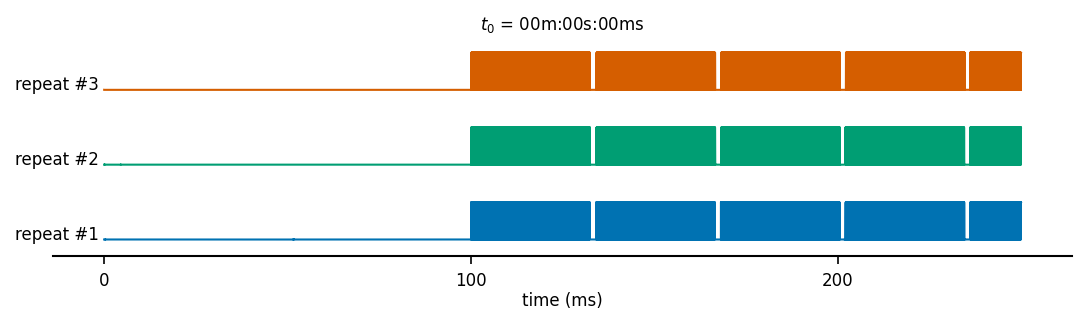

In [166]:
plot(data, 0, 250)

## Onset zoomed

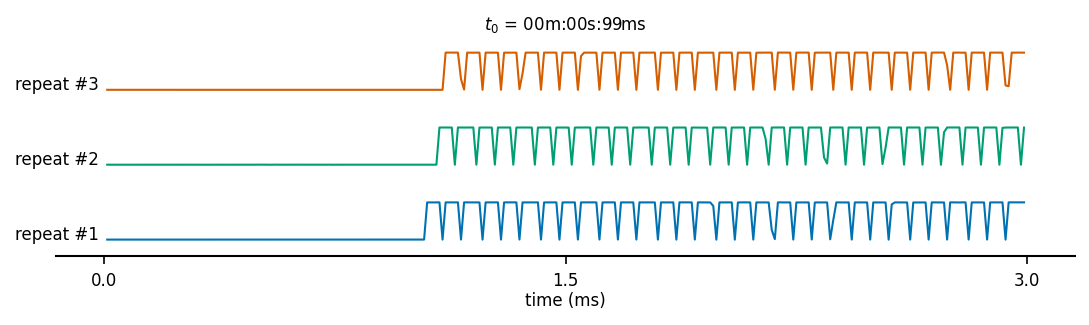

In [167]:
plot(data, 0.099, 3)

## Later

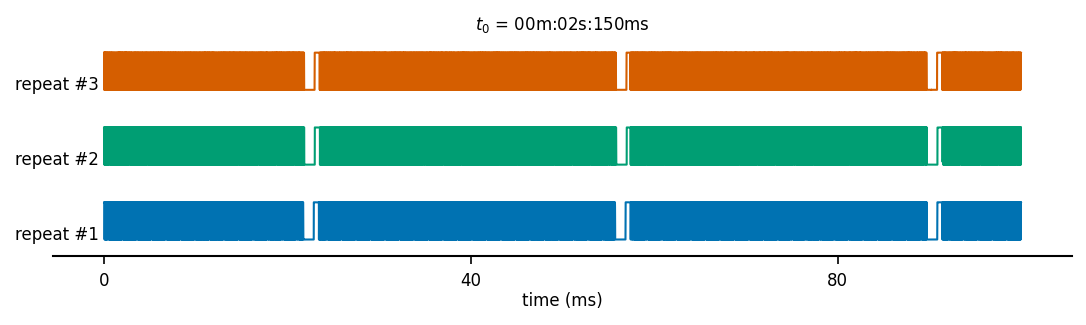

In [168]:
plot(data, 2.15, 100)

# Binarize and find common inactive periods

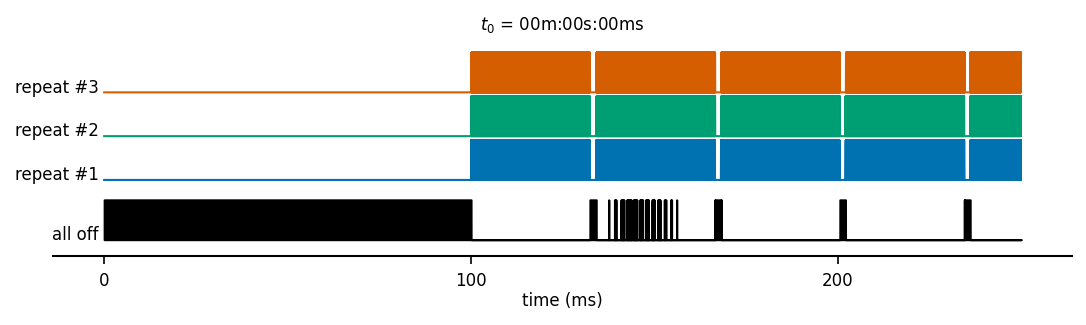

In [169]:
threshold = 0.1
nmax = np.inf
for i in range(len(data)):
    data[i]['binary'] = np.zeros(len(data[i]['t']), dtype=bool)
    data[i]['binary'][ (data[i]['pockels'] >= threshold) ] = True
    nmax = min([nmax, len(data[i]['t'])])
inactive = np.zeros(nmax, dtype=bool)
cond = np.sum([data[i]['binary'][:nmax] for i in range(len(data))], axis=0)==0
inactive[cond] = True
plot(data, 0, 250, key='binary', inactive=inactive)

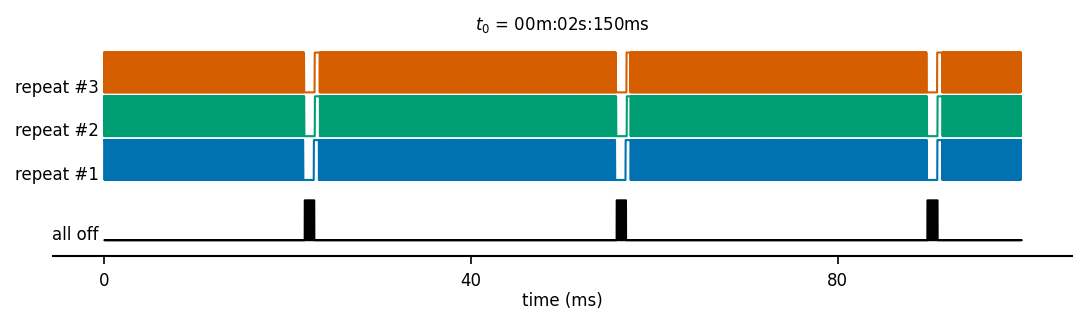

In [170]:
plot(data, 2.15, 100, key='binary', inactive=inactive)

### Evaluate the fraction of common inactive intervals

Text(0.5, 1.0, 'single vs all')

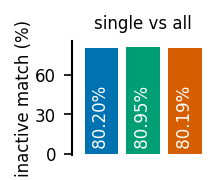

In [171]:
tmin = 0.2
tmax = 2.25 # after this problem with channel 1

fig, ax = pt.figure(figsize=(1,1.2))
for i in range(len(data)):
    cond = (data[i]['t'][:nmax]>tmin) & (data[i]['t'][:nmax]<tmax)
    match = (data[i]['binary'][:nmax][cond]==0) & (inactive[cond]==0)
    ax.bar([i], [100.*np.sum(match)/np.sum(data[i]['binary'][:nmax][cond]==0)])
    pt.annotate(ax, ' %.2f%%' % (100.*np.sum(match)/np.sum(data[i]['binary'][:nmax][cond]==0)), (i, 0),
                xycoords='data', ha='center', va='bottom', color='w', rotation=90)
    
pt.set_plot(ax, ['left'], ylabel='inactive match (%)')
ax.set_title('single vs all')

### Find the length of the "off" intervals

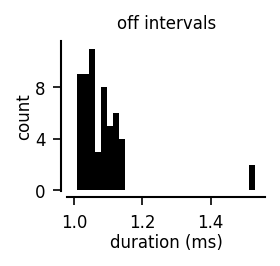

In [196]:
t = data[0]['t'][:nmax]
cond = (t>tmin) & (t<tmax)
up_cond = inactive[cond][1:] & (~inactive[cond][:-1])
down_cond = inactive[cond][:-1] & (~inactive[cond][1:])
intervals = t[cond][1:][down_cond]-t[cond][1:][up_cond]
plt.hist(1e3*intervals[intervals>1e-3], bins=30, color='k')
pt.set_plot(plt.gca(), xlabel='duration (ms)', ylabel='count', title='off intervals')

## Generating a prediction for the off periods

> /!\ need a very precise estimate of the frame period /!\\

--> the one in the `xml` file of Prairie doesn't include the off period...

To generate a good estimate, launch a 2P acquisition with a very high number of frames (>10000)
take the time of the last frame (e.g. `t=2024.212218594` for `n=59559` frames).

Then make a high precision division of the two:
```
framePeriod = np.float64(2024.212218594)/np.float64(59559.)
print(framePeriod)

> 0.033986672351684885
```

In [249]:
t0 =0.1
duration, security = 1e-3*1.3, 0.1*1e-3
framePeriod = np.float64(2024.212218594)/np.float64(59559.)
predicted = np.zeros(len(inactive), dtype=bool)
tt=t0+framePeriod
predicted[ ( ((t-t0)%framePeriod)>(framePeriod-duration-security) ) &\
             ( ((t-t0)%framePeriod)<(framePeriod-security) )  ] = True

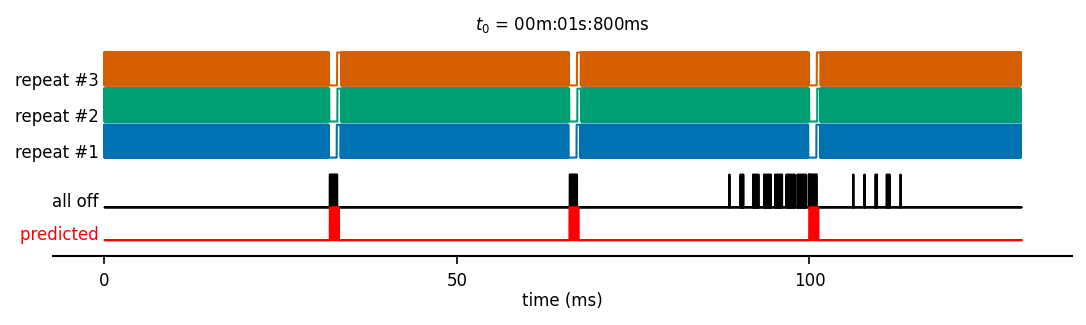

In [253]:
plot(data, 1.8, 130, key='binary', inactive=inactive, predicted=predicted)